<a href="https://colab.research.google.com/github/Ardavic/FlowerClassification/blob/main/FlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
!unzip gdrive/MyDrive/AI/Dataset/flowers.zip > /dev/null

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import os 
from sklearn.utils import shuffle
from numpy import save
from torch.nn.modules import pooling
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.linear import Linear
from torch.utils import data
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from numpy import load

In [3]:
def iterate_thr_data():
    
  images_as_arrays = []
  names_as_integers = []

  for type_i, file_name in enumerate(os.listdir('flowers')):
    if file_name != '.ipynb_checkpoints':
      
      for element in os.listdir(f'flowers/{file_name}'):
        image = Image.open(f'flowers/{file_name}/{element}')
        resized = image.resize((256, 256))
        np_image = np.array(resized)
        np_image = np.transpose(np_image,(2, 0, 1))

        images_as_arrays.append(np_image)
        names_as_integers.append(type_i)
      print(f'Done with: {file_name}s')
     
  images = np.stack(images_as_arrays, axis=0)
  labels = np.array(names_as_integers)
  images, labels = shuffle(images, labels)
  
  save('images.npy', images)
  save('labels.npy', labels)
  
   #return images, labels

In [31]:
os.remove('flowers/dandelion/flickr.pyc')

In [35]:
iterate_thr_data()

Done with: dandelions
Done with: tulips
Done with: roses
Done with: sunflowers
Done with: daisys


In [4]:
def array_to_loader(x, y, train_size, batch_size):
  
  x_train, x_test = torch.FloatTensor(x[:train_size, :,:,:]), torch.FloatTensor(x[train_size:, :,:,:])
  y_train, y_test = torch.LongTensor(y[:train_size,]) , torch.LongTensor(y[train_size:,])

  train_ds = TensorDataset(x_train, y_train)
  test_ds = TensorDataset(x_test, y_test)

  train_loader = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
  test_loader = DataLoader(test_ds, batch_size=batch_size)

  return train_loader, test_loader

In [5]:
def build_network():
    
  return nn.Sequential(
        
    nn.Conv2d(3, 6, 3, stride=2, padding=1), #128x128x6
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),  #64x64x6

    nn.Conv2d(6,6, 5,stride=2, padding=0), #30x30x6
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #15x15x6

    nn.Conv2d(6,6, 3, stride=1, padding=1), #14x14x6
    nn.BatchNorm2d(6),
    nn.ReLU(),
    nn.MaxPool2d(2,2), #7x7x6

    nn.Flatten(),

    nn.Dropout(p = 0.2),
    nn.Linear(294, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Linear(64, 6),
    nn.Softmax(dim=1)

    )

In [6]:
def accuracy_for_softmax(output_tensor, target_tensor):

  pred = torch.max(output_tensor, 1)[1]
  
  acc = torch.eq(pred, target_tensor).sum().item() / target_tensor.size()[0]
  return acc

In [7]:
def loss_and_acc(batch_i, mean_loss, mean_acc, loss, acc):
    
  new_loss = ( (batch_i * mean_loss) + loss.item() ) / (batch_i + 1)
  new_acc = ( (batch_i * mean_acc) + acc ) / (batch_i + 1)

  return new_loss, new_acc

In [8]:
def trainer(train_loader, model, optimizer, criteration):
    
  train_loss, train_acc = 0, 0,

  for batch_i, (x_train, y_train) in enumerate(train_loader):
      
    optimizer.zero_grad()

    output = model(x_train)

    loss = criteration(output, y_train)
    loss.backward()

    optimizer.step()

    acc = accuracy_for_softmax(output, y_train)
    
    train_loss, train_acc = loss_and_acc(batch_i, train_loss, train_acc, loss, acc)

  return train_loss, train_acc

In [11]:
def tester(test_loader, model, criteration):
  
  test_loss, test_acc = 0, 0

  for batch_i, (x_test, y_test) in enumerate(test_loader):

    with torch.no_grad():
        output = model(x_test)
    
    loss = criteration(output, y_test)
    acc = accuracy_for_softmax(output, y_test)

    test_loss, test_acc = loss_and_acc(batch_i, test_loss, test_acc, loss, acc)
  
  return test_loss, test_acc

In [12]:
def main():

  TRAIN_SIZE = 4000
  BATCH_SIZE = 32
  EPOCHS = 20

  images = load('images.npy')
  labels = load('labels.npy')

  train_loader, test_loader = array_to_loader(images, labels, TRAIN_SIZE, BATCH_SIZE)

  model = build_network()
  optimizer = Adam(model.parameters())
  criteration = nn.CrossEntropyLoss()
  

  train_losses, train_accs = [], []
  test_losses, test_accs = [], []

  for EPOCH in range(EPOCHS):

    train_loss, train_acc = trainer(train_loader, model, optimizer, criteration)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_loss , test_acc = tester(test_loader, model, criteration)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f'Epoch:--{EPOCH}-- TrainLoss: {train_loss} TrainAccuracy: {train_acc} TestLoss: {test_loss} TestAccuracy: {test_acc}')

  plt.figure()
  plt.plot(train_losses)
  plt.plot(test_losses)
  plt.legend(["TrainLoss", "TestLoss"])
  plt.savefig('losses')

  plt.figure()
  plt.plot(train_accs)
  plt.plot(test_accs)
  plt.legend(["TrainAccuracy", "TestAccuracy"])
  plt.savefig('accuracies')


Epoch:--0-- TrainLoss: 1.6069804077148437 TrainAccuracy: 0.4625 TestLoss: 1.536398540843617 TestAccuracy: 0.524621212121212
Epoch:--1-- TrainLoss: 1.4809340791702272 TrainAccuracy: 0.5884999999999999 TestLoss: 1.4706605672836304 TestAccuracy: 0.5757575757575757
Epoch:--2-- TrainLoss: 1.427092670440674 TrainAccuracy: 0.6330000000000002 TestLoss: 1.4755866744301536 TestAccuracy: 0.5473484848484849
Epoch:--3-- TrainLoss: 1.408834836959839 TrainAccuracy: 0.6395000000000001 TestLoss: 1.4524678967215798 TestAccuracy: 0.6089015151515151
Epoch:--4-- TrainLoss: 1.3876413116455077 TrainAccuracy: 0.6594999999999998 TestLoss: 1.4436432339928367 TestAccuracy: 0.587121212121212
Epoch:--5-- TrainLoss: 1.3793709096908573 TrainAccuracy: 0.67075 TestLoss: 1.4308244640176946 TestAccuracy: 0.5984848484848485
Epoch:--6-- TrainLoss: 1.3640465974807734 TrainAccuracy: 0.6829999999999997 TestLoss: 1.4469555074518377 TestAccuracy: 0.5928030303030303
Epoch:--7-- TrainLoss: 1.3501261320114135 TrainAccuracy: 0.695

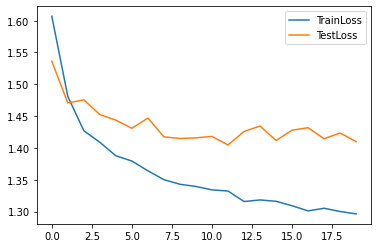

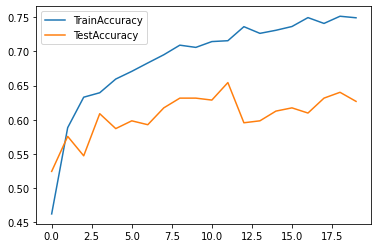

In [13]:
main()